# Distributions

Suppose we are trying to emulate a simulator's outputs $f(x) \in \mathbb{R}^d$. If we consider a batch of $n$ outputs then then we'd want to retrieve output means $\mu \in \mathbb{R}^{nd}$ and covariances $\Sigma \in \mathbb{R}^{nd \times nd}$.
$$
\Sigma =
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12} & \cdots & \Sigma_{1n} \\[6pt]
\Sigma_{21} & \Sigma_{22} & \cdots & \Sigma_{2n} \\[6pt]
\vdots      & \vdots      & \ddots & \vdots      \\[6pt]
\Sigma_{n1} & \Sigma_{n2} & \cdots & \Sigma_{nn}
\end{bmatrix} \in \mathbb{R}^{nd \times nd}
\quad \text{s.t.} \quad 
\Sigma_{ij} \in \mathbb{R}^{d \times d}
$$
where $\Sigma_{ii}$ is the *marginal covariance* and $\Sigma_{ij}$ is the *cross-covariance*.

There are a couple of scenarios we want to consider:
1. **Full**: no simplification to the above covariance matrix.
2. **Block-diagonal**: $\Sigma_{ij} = 0$ for all $i\neq j$, i.e. no correlations between samples.
3. **Diagonal**: $\Sigma_{ij} = 0$ for all $i\neq j$ and $\Sigma_{ii}^{(a, b)} = 0$ for all $a \neq b$, i.e. no correlations between sample dimensions.
4. **Seperable**: $\Sigma = \Sigma_{N} \otimes \Sigma_{D}$ s.t. $\Sigma_{\text{N}} \in \mathbb{R}^{n \times n}$ and $\Sigma_{\text{D}} \in \mathbb{R}^{d \times d}$, i.e. correlations between samples and dimensions are modelled seperately. 

Note that:
$$
\begin{aligned}
\text{Full} &\supseteq \text{Block-Diagonal} \supseteq \text{Diagonal} \\
\text{Full} &\supseteq \text{Seperable}
\end{aligned}
$$

In [1]:
import torch, time, numpy as np, pandas as pd
from autoemulate.experimental.data.gaussian import *
from dataclasses import dataclass
from typing import List, Dict
%load_ext autoreload
%autoreload 2

Remember that our simulation can be viewed as a function
$$
f: \mathcal{X} \to \mathcal{Y}.
$$
Suppose that the output space if `d`-dimensional, i.e. $\mathcal{Y} \subseteq \mathbb{R}^d$, and suppose we choose `n` sampling locations in the input space $\mathcal{X}$. Suppose that, for each each sampling location, we sample `k` times. Then we'd get a tensor of shape `(k, n, d)`. Let's start with that.

In [2]:
k, n, d = 1000, 50, 3
samples = torch.rand(k, n, d)

## Structured covariances

By using structured covariances we can use theoretical properties to speed up the computation of things such as the log determinant, trace, and maximum eigenvalue of the covariance matrix.

In [6]:
def verify_dense(classes: List[Structured], k: int, n: int, d: int):
    samples = torch.rand(k, n, d)
    for cls in classes:
        dist_struct = cls.from_dense(Empirical(samples))
        dist_dense = dist_struct.to_dense()
        res_dense = torch.stack([
            dist_dense.logdet(),
            dist_dense.trace(),
            dist_dense.max_eig()
        ])
        res_struct = torch.stack([
            dist_struct.logdet(),
            dist_struct.trace(),
            dist_struct.max_eig()
        ])
        print(f"{cls.__name__}")
        print(res_dense)
        print(res_struct)
        print()


verify_dense([Block_Diagonal, Diagonal, Dirac], k, n, d)

Block_Diagonal
tensor([-3.7325e+02,  1.2475e+01,  9.7242e-02])
tensor([-3.7325e+02,  1.2475e+01,  9.7242e-02])

Diagonal
tensor([-3.7310e+02,  1.2475e+01,  8.9905e-02])
tensor([-3.7310e+02,  1.2475e+01,  8.9905e-02])

Dirac
tensor([-inf, 0., 0.])
tensor([-inf, 0., 0.])



In [120]:
def difference(f0, f1):
    t0 = time.perf_counter()
    r0 = f0()
    t1 = time.perf_counter()
    T0 = t1 - t0
    r1 = f1()
    t2 = time.perf_counter()
    T1 = t2 - t1
    return float(T1 - T0), float(abs(r1 - r0))

In [124]:
def compare(
    classes: List[Structured], 
    n_list: List[int],
    d_list: List[int],
    n_runs: int
) -> List[Dict[str, Any]]:
    results = []
    for n in n_list:
        for d in d_list:
            for cls in classes:
                for _ in range(n_runs):
                    dense   = Empirical(torch.randn(k, n, d))
                    struct  = cls.from_dense(dense)
                    for fd, fs in zip(
                        [struct.logdet, struct.trace, struct.max_eig],
                        [dense.logdet,   dense.trace,   dense.max_eig]
                    ):
                        t, e = difference(fd, fs)
                        results.append({
                            "Type":      cls.__name__,
                            "Dimension": n * d,
                            "Metric":    fd.__name__,
                            "Time":      t,
                            "Error":     e
                        })
    return results

In [168]:
results = compare(
    classes=[Block_Diagonal, Diagonal, Separable, Dirac],
    n_list=[10, 20],
    d_list=[3, 6, 8],
    n_runs=100
)
results = pd.DataFrame(results)

In [169]:
summary = (
    results
    .groupby(['Type','Dimension','Metric'])
    .agg(
        time_mean  = ('Time',  'mean'),
        time_std   = ('Time',  'std'),
        error_mean = ('Error', 'mean'),
        error_std  = ('Error', 'std'),
    )
    .reset_index()
)

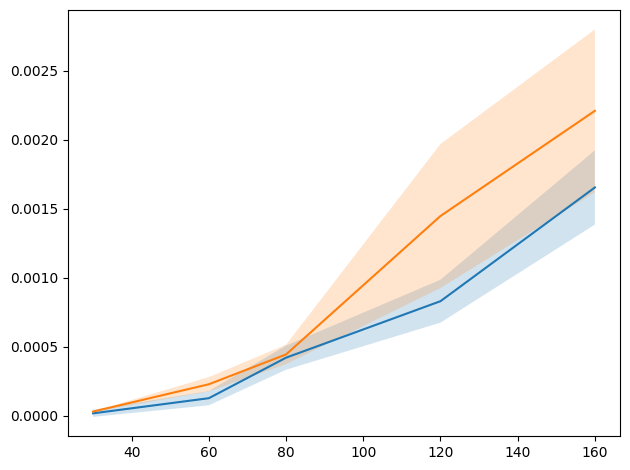

In [171]:
import matplotlib.pyplot as plt
s = summary[
    (summary['Type'] == 'Block_Diagonal') &
    (summary['Metric'] == 'max_eig')
]
plt.plot(s['Dimension'], s['time_mean'])
plt.fill_between(
    s['Dimension'],
    s['time_mean'] - s['time_std'],
    s['time_mean'] + s['time_std'],
    alpha=0.2
)
s = summary[
    (summary['Type'] == 'Diagonal') &
    (summary['Metric'] == 'max_eig')
]
plt.plot(s['Dimension'], s['time_mean'])
plt.fill_between(
    s['Dimension'],
    s['time_mean'] - s['time_std'],
    s['time_mean'] + s['time_std'],
    alpha=0.2
)
plt.tight_layout()
plt.show()

## Ensemble of Gaussians

Let $K \in \mathbb{N}$ be the number of Gaussians. Then the mean and covariance of an ensemble of Gaussians is given by

$$
\mu
= \frac{1}{K}
  \sum_{i=1}^{K}
    \mu_i,
$$
$$
\Sigma
= \frac{1}{K}
  \sum_{i=1}^{K}
    \Sigma_i
+
  \frac{1}{K - 1}
  \sum_{i=1}^{K}
    \bigl(\mu_i - \mu\bigr)
    \bigl(\mu_i - \mu\bigr)^\top.
$$

In [47]:
dist_ens = Ensemble([
    dist_dense, dist_bd, dist_diag, dist_dirac, dist_sep
])
dist_ens.logdet(), dist_ens.trace(), dist_ens.max_eig()

(tensor(-29.7939), tensor(0.4056), tensor(0.1747))